<a href="https://colab.research.google.com/github/MajorFeijo/RNA-e-Deep-Learning-CESAR-School-2023.02/blob/main/Atividade%20aula%203.2/3_2_LogisticRegressionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [ ]:
! pip install Pillow

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [56]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [57]:
!ls MNIST

processed  raw


In [58]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [59]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

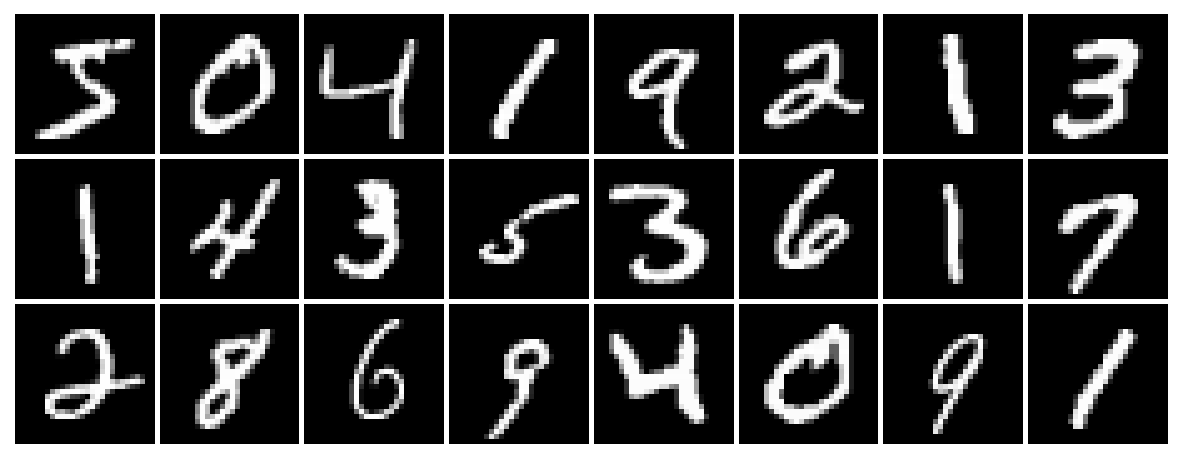

In [60]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


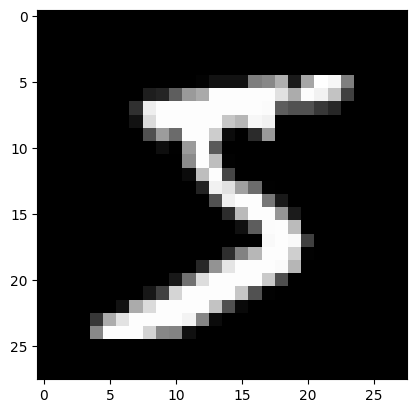

In [61]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [62]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [63]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.0715, -0.1915, -0.2995, -0.2919,  0.1301,  0.0131,  0.5896,  0.2112,
         -0.0083,  0.1043],
        [-0.1508, -0.2861, -0.0567, -0.4709, -0.1277, -0.1034,  0.0640, -0.0394,
          0.0957,  0.2038],
        [-0.1797, -0.0068, -0.1430,  0.2598,  0.1845,  0.0537,  0.0925,  0.1992,
         -0.1221, -0.0058],
        [ 0.0498,  0.0854,  0.1204, -0.0164,  0.1604, -0.0303, -0.1451,  0.0983,
          0.1613,  0.0341],
        [-0.0579, -0.4089, -0.0100, -0.0575,  0.0847,  0.1052, -0.0028,  0.3224,
          0.1291,  0.1664]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [64]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [65]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-jcjgv7_w
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-jcjgv7_w
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done


In [66]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3138, grad_fn=<NllLossBackward0>)

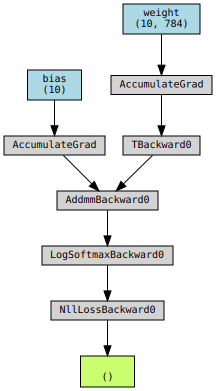

In [67]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [48]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [49]:
print('Final loss:', loss.item())

Final loss: 0.2653034031391144


### Visualizando gráfico de perda durante o treinamento

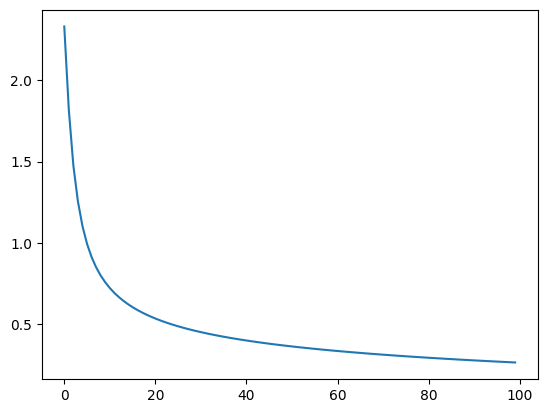

In [50]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [51]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.939


### Matriz de confusão com dados de treinamento e teste

In [52]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,2,0,0,0,1,2,1,0
2,0,1,89,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,81,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,2,1,0,0,0,111,0,3
8,0,2,2,0,0,2,1,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


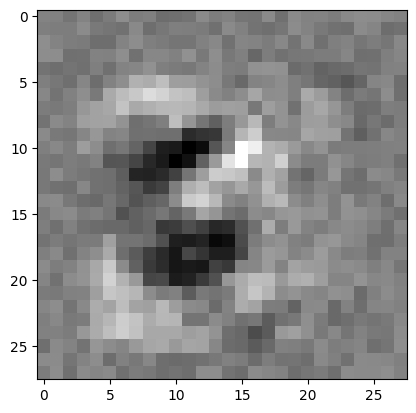

In [19]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

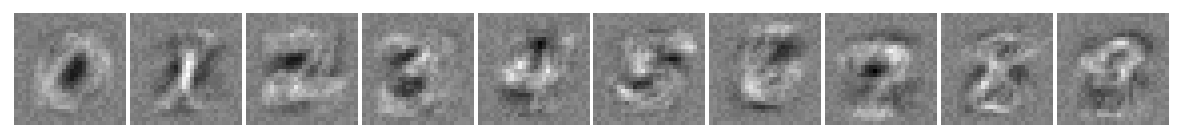

In [20]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [26]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    print(f"Epoch {i+1}: Loss {loss.item()}, Accuracy {accuracy}")

Epoch 1: Loss 0.07409704476594925, Accuracy 0.998
Epoch 2: Loss 0.07398202270269394, Accuracy 0.998
Epoch 3: Loss 0.07386733591556549, Accuracy 0.998
Epoch 4: Loss 0.0737529844045639, Accuracy 0.998
Epoch 5: Loss 0.07363896071910858, Accuracy 0.998
Epoch 6: Loss 0.07352524995803833, Accuracy 0.998
Epoch 7: Loss 0.07341191172599792, Accuracy 0.998
Epoch 8: Loss 0.0732988715171814, Accuracy 0.998
Epoch 9: Loss 0.07318617403507233, Accuracy 0.998
Epoch 10: Loss 0.07307378947734833, Accuracy 0.998
Epoch 11: Loss 0.07296174019575119, Accuracy 0.998
Epoch 12: Loss 0.07285001128911972, Accuracy 0.998
Epoch 13: Loss 0.07273861765861511, Accuracy 0.998
Epoch 14: Loss 0.07262753695249557, Accuracy 0.998
Epoch 15: Loss 0.0725167766213417, Accuracy 0.998
Epoch 16: Loss 0.0724063292145729, Accuracy 0.998
Epoch 17: Loss 0.07229620218276978, Accuracy 0.998
Epoch 18: Loss 0.07218638807535172, Accuracy 0.998
Epoch 19: Loss 0.07207690179347992, Accuracy 0.998
Epoch 20: Loss 0.0719677209854126, Accuracy 

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

In [68]:
import numpy as np
import matplotlib.pyplot as plt

losses = []
grads_visualization = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Acessa os gradientes referentes à classe do dígito 4
    gradients_4 = model.weight.grad[:, 4].detach().numpy()
    #grads_visualization.append(gradients_4)

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    print(f"Epoch {i+1}: Loss {loss.item()}, Accuracy {accuracy}, Gradiente do digito 4 {gradients_4}")



Epoch 1: Loss 2.313758611679077, Accuracy 0.1, Gradiente do digito 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 2: Loss 1.8119193315505981, Accuracy 0.599, Gradiente do digito 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 3: Loss 1.478383183479309, Accuracy 0.763, Gradiente do digito 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 4: Loss 1.2544828653335571, Accuracy 0.769, Gradiente do digito 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 5: Loss 1.102288842201233, Accuracy 0.815, Gradiente do digito 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 6: Loss 0.99147629737854, Accuracy 0.819, Gradiente do digito 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 7: Loss 0.9098150134086609, Accuracy 0.835, Gradiente do digito 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 8: Loss 0.846831738948822, Accuracy 0.838, Gradiente do digito 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 9: Loss 0.7964933514595032, Accuracy 0.85, Gradiente do digito 4 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Epoch 10: Loss 0.7550640106201172, Accuracy 0.855, Gradiente do digito 4 

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
      Resposta: Amostras de treinamento: 1000,  Dimensões dos dados das imagens 28 x 28: torch.Size([1000 x 28 x 28])
2. Qual é o shape da saída da rede?
      Resposta: 1000 x 10
      
3. Qual é o número total de parâmetros da rede, incluindo o bias?
      Resposta: 28 x 28 x 10 + 10 = 7850

# Aprendizados

Ao inserir o código no laço de treinamento para imprimir o número da época, a perda e a acurácia, obteve-se um resultado claro e organizado que permite monitorar o desempenho do modelo ao longo do treinamento. Isso é crucial para entender como o modelo está aprendendo e se está convergindo para uma solução satisfatória. Os resultados mostram uma diminuição consistente na perda e um aumento correspondente na acurácia, o que indica que o modelo está aprendendo e melhorando conforme mais épocas são executadas.

Já ao inserir o código no laço de treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, não foram observadas mudanças nos valores dos gradientes ao longo do treinamento. Isso pode indicar que o modelo não está aprendendo adequadamente a distinguir a classe do dígito 4 dos outros dígitos durante o treinamento. Seria necessário investigar mais a fundo as razões por trás desse comportamento e possivelmente realizar ajustes no modelo ou na abordagem de treinamento para melhorar o aprendizado dessa classe específica.

Em resumo, os resultados obtidos mostram que o modelo está aprendendo de maneira geral, conforme evidenciado pela redução na perda e aumento na acurácia ao longo das épocas. No entanto, a falta de mudanças nos gradientes referentes à classe do dígito 4 sugere que há espaço para melhorias na capacidade do modelo de aprender a distinguir essa classe específica.

A matriz de entrada na rede possui o shape de 1000 amostras de treinamento, cada uma com dimensões de imagem de 28 x 28 pixels, resultando em uma dimensão total de torch.Size([1000 x 28 x 28]).

A saída da rede tem um shape de 1000 x 10, o que significa que para cada uma das 1000 amostras de entrada, a rede produz uma saída com 10 valores, representando as probabilidades de pertencer a cada uma das 10 classes possíveis.

O número total de parâmetros da rede, incluindo o bias, é calculado como o número de conexões entre as camadas mais o número de biases em cada camada. Neste caso, temos (28 x 28) x 10 + 10 = 7850 parâmetros.





